In [4]:
import os, pickle
from tqdm import tqdm  # Import tqdm for progress tracking
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import pyemma
import pyemma.coordinates as coor
from joblib import Parallel, delayed


## Load in important functions

In [5]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)
    

In [6]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

## Prepare the Data and the log (indicating of the data state)

In [7]:
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/all_omega.pkl").array_list  # This is an (85, x, 3) array
# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")

First array shape after conversion: (9002, 3)


In [8]:
# Find the minimum x-dimension across all arrays
min_x = min(arr.shape[0] for arr in all_cistrans)
print(f"Shortest x in all_cistrans: {min_x}")

Shortest x in all_cistrans: 3001


In [9]:
# Define paths
traj_path = '../PROJ12462traj'
log_path = '../log'

all_state = []

# Iterate over RUN and CLONE indices
for r in range(2, 3):  # Only r=2 for now
    for c in range(100):  # Iterate over c=0 to c=99
        csv_log = f"{log_path}/RUN{r}_CLONE{c}_log.csv"
        input_xtc_file = f"{traj_path}/r{r}c{c}_inte.xtc"

        # Corrected condition: Check if either file is missing
        if not os.path.exists(csv_log) or not os.path.exists(input_xtc_file):
            print(f"Missing file(s): {input_xtc_file if not os.path.exists(input_xtc_file) else ''}")
            print(f"Missing log file(s): {csv_log if not os.path.exists(csv_log) else ''}")
            continue

        # Load log and convert states
        df_log = pd.read_csv(csv_log, header=0)
        log = df_log.iloc[:, 0].values  # Convert to NumPy array
        all_state.append(log)

all_state

Missing file(s): ../PROJ12462traj/r2c8_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c32_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c46_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c48_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c49_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c57_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c59_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c77_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c79_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c87_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c91_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c93_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c95_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c96_inte.xtc
Missing log file(s): 
Missing

[array([0, 2, 1, ..., 2, 3, 2]),
 array([0, 1, 3, ..., 1, 2, 1]),
 array([0, 1, 3, ..., 0, 1, 1]),
 array([0, 2, 0, ..., 1, 1, 0]),
 array([0, 2, 1, ..., 2, 2, 2]),
 array([0, 2, 1, ..., 0, 1, 1]),
 array([0, 2, 1, ..., 3, 1, 2]),
 array([0, 3, 2, ..., 3, 2, 2]),
 array([0, 3, 0, ..., 3, 1, 2]),
 array([0, 2, 1, ..., 0, 1, 0]),
 array([0, 2, 0, ..., 3, 3, 0]),
 array([0, 2, 3, ..., 2, 3, 3]),
 array([0, 2, 2, ..., 0, 0, 1]),
 array([0, 3, 2, ..., 3, 0, 0]),
 array([0, 1, 3, ..., 0, 1, 1]),
 array([0, 2, 3, ..., 1, 0, 1]),
 array([0, 2, 1, ..., 3, 2, 3]),
 array([0, 2, 0, ..., 3, 2, 3]),
 array([0, 1, 3, ..., 3, 3, 3]),
 array([0, 1, 3, ..., 1, 0, 0]),
 array([0, 2, 1, ..., 1, 1, 1]),
 array([0, 3, 0, ..., 1, 1, 0]),
 array([0, 1, 1, ..., 3, 3, 1]),
 array([0, 1, 0, ..., 2, 1, 2]),
 array([0, 1, 1, ..., 3, 3, 2]),
 array([0, 2, 3, ..., 1, 2, 2]),
 array([0, 2, 0, ..., 1, 0, 1]),
 array([0, 2, 3, ..., 0, 2, 1]),
 array([0, 1, 1, ..., 0, 2, 1]),
 array([0, 2, 2, ..., 3, 2, 3]),
 array([0,

In [10]:
import numpy as np

unique_states = np.unique(all_state[9])
print(unique_states)

[0 1 2 3]


### Create New Data Set

In [11]:
# Assuming all_cistrans and all_state are lists of numpy arrays
new_all = []

for i in range(len(all_cistrans)):  # Loop over 85 trajectories
    x_len = all_cistrans[i].shape[0]  # Get the x dimension from all_cistrans

    # Trim all_state[i] to match the first x_len frames
    state_trimmed = all_state[i][:x_len]  # Ensure same length along x

    # Reshape state to (x, 1) if necessary
    state_trimmed = state_trimmed.reshape(-1, 1)  # Ensure shape (x, 1)

    # Concatenate along the last axis to get (x, 4)
    combined = np.concatenate((all_cistrans[i], state_trimmed), axis=1)

    # Append to new list
    new_all.append(combined)


new_all[4]

array([[1, 1, 1, 0],
       [1, 0, 0, 2],
       [1, 0, 1, 1],
       ...,
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 0]])

## Functions 

In [12]:
import numpy as np

def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 2) array of states into (N, M) indices in [0..11].

    Each state is a pair [a, x] where:
      - a ∈ {0, 1} (binary state)
      - x ∈ {0, 1, 2, 3} (substate)
      - Output index = 4 * a + x

    If any entry contains a NaN, the corresponding output is NaN.

    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 2). Each (a, x) pair will be converted.

    Returns
    -------
    indexed_states : np.ndarray
        A float array of shape (N, M) with values in [0..11] or NaN.

    Raises
    ------
    ValueError
        If input shape is not (N, M, 2).
    
    Examples
    --------
    >>> state_to_index_vectorized([[[0, 2], [1, 3]], [[1, 0], [np.nan, 1]]])
    array([[ 2.,  7.],
           [ 4., nan]])
    """
    # Convert input to numpy array of float type (to allow NaNs)
    all_state_array = np.array(all_state, dtype=float)

    # Validate input shape
    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 2:
        raise ValueError(f"Expected input shape (N, M, 2), got {all_state_array.shape}")

    # Detect any rows with NaN values in (a, x)
    nan_mask = np.isnan(all_state_array).any(axis=-1)  # shape: (N, M)

    # Initialize output array with NaNs
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)

    # Mask for valid entries
    valid_mask = ~nan_mask

    # Perform vectorized computation only on valid rows
    weights = np.array([4, 1], dtype=float)
    valid_data = all_state_array[valid_mask]  # shape (?, 2)
    indexed_states[valid_mask] = valid_data @ weights  # dot product for index

    return indexed_states


In [13]:
import numpy as np

def index_to_state(index):
    """
    Converts an index (0..11) back into a (2,) array [a, x], where:
      - a ∈ {0, 1}
      - x ∈ {0, 1, 2, 3}

    Inverse of:
        index = 4 * a + x

    Parameters
    ----------
    index : int or array-like of ints
        Integer(s) in the range [0, 11].

    Returns
    -------
    state : np.ndarray
        If input is a scalar, returns a (2,) array [a, x].
        If input is array-like, returns shape (..., 2).
    
    """
    index = np.asarray(index)

    if np.any((index < 0) | (index > 11)):
        raise ValueError(f"Index out of range: {index}. Expected values in 0..11.")

    a = index // 4
    x = index % 4

    return np.stack([a, x], axis=-1)


In [ ]:
def compute_transition_matrix(subset, num_states, lagtime, pseudocount=0.25):
    """Compute transition matrix for a given subset of trajectories."""
    
    C = np.zeros((num_states, num_states))  # Initialize count matrix

    for traj in subset:
        traj = np.asarray(traj)  # ensure it's indexable

        for t in range(len(traj) - lagtime):
            from_state = traj[t]
            to_state = traj[t + lagtime]

            # Skip NaN transitions
            if np.isnan(from_state) or np.isnan(to_state):
                continue

            # Convert states to integers for indexing
            from_state = int(from_state)
            to_state = int(to_state)

            # Count transitions
            C[from_state, to_state] += 1.0

    # Add pseudocounts to avoid zero entries
    C += pseudocount

    # Normalize rows to get probabilities
    row_sums = C.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero
    T = C / row_sums

    if not isinstance(T, np.ndarray) or T.shape != (num_states, num_states):
        raise ValueError(f"[ERROR] Invalid transition matrix shape: {T.shape if isinstance(T, np.ndarray) else type(T)}")        
    
    return T

In [24]:
def get_transition_matrices(n_trajs, num_states, lagtime, cluster_size=10, pseudocount=0.25, n_jobs=-1):
    """
    Compute transition matrices for subsets of trajectories in parallel.
    """

    num_trajs = n_trajs.shape[0]  # Number of trajectories
    
    # Shuffle indices
    indices = np.arange(num_trajs)
    np.random.shuffle(indices)

    # Split into clusters
    clusters = [indices[i:i + cluster_size] for i in range(0, num_trajs, cluster_size)]

    # Merge last small cluster with the second-last if needed
    if len(clusters) > 1 and len(clusters[-1]) < cluster_size:
        clusters[-2] = np.concatenate([clusters[-2], clusters[-1]])  
        clusters.pop()

    # Parallel computation of transition matrices
    def process_cluster(cluster):
        subset = n_trajs[cluster]
        # Call your existing compute_transition_matrix
        T = compute_transition_matrix(subset, num_states, lagtime, pseudocount)

            # Debug check
        if not isinstance(T, np.ndarray) or T.ndim != 2:
            print(f"[ERROR] compute_transition_matrix returned invalid type/shape: {type(T)}, shape={getattr(T, 'shape', None)}")
            print(f"[DEBUG] Cluster indices: {cluster}")
            print(f"[DEBUG] Subset shape: {subset.shape}")
            raise ValueError("Transition matrix must be a 2D array")
        return T

    # Use joblib's Parallel for parallelism. 
    # `delayed(process_cluster)(c)` calls `process_cluster(c)` lazily.
    # `n_jobs=-1` uses all available CPUs unless specified otherwise.
    transition_matrices = Parallel(n_jobs=n_jobs)(
        delayed(process_cluster)(cluster) 
        for cluster in tqdm(clusters, desc="Computing transition matrices", unit="cluster")
    )

    return transition_matrices


In [16]:
def compute_stationary_distribution(T, lagtime):
    """Compute the stationary distribution of a transition matrix T.
    
    INPUT:
    T - Transition matrix where T_ij is the probability of transitioning i -> j.
    
    RETURN:
    pi - The stationary distribution (1D NumPy array).
    t2 - The implied timescale (in units of steps).
    """
    try:
        # Compute the implied timescale
        evals = np.linalg.eigvals(T.transpose() )  # will be something like [0.99754545 1.        ]
        evals_sorted = np.sort(evals)      # ascending order
        mu2 = evals_sorted[-2]            # second-largest eigenvalue
        #print('mu2', mu2, 'evals', evals, 'evals_sorted', evals_sorted, 'T', T)
        
        t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
        #print('evals_sorted', evals_sorted, 'mu2', mu2, 't2', t2)

        # Compute the stationary state distribution 
        n_states = T.shape[0]
        A = np.transpose(T) - np.eye(n_states)  # (T' - I)
        A = np.vstack([A, np.ones(n_states)])  # Append normalization row
        b = np.zeros(n_states + 1)
        b[-1] = 1  # Ensure probability sums to 1
        
        # Solve for stationary distribution using least squares
        pi, *_ = np.linalg.lstsq(A, b, rcond=None)
        
        # Ensure non-negative values and normalize
        pi = np.maximum(pi, 0)  # Prevent small negative values due to numerical error
        pi /= np.sum(pi)  # Normalize to sum to 1

    except Exception as e:
        print(f"Error computing stationary distribution: {e}")
        t2 = np.nan
        pi = None

    return pi, t2

## Calculating the stationary population and implied timescale

In [19]:
ntraj = len(new_all)
print(ntraj)

# Find the longest traj
maxlength = max( [ len(new_all[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 4) )

for i in range(ntraj):
    n = len(new_all[i])
    traj[i, 0:n, :] = new_all[i]

traj

85
maxlength 37002


array([[[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        [ 0.,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  1.],
        [ 0.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.

In [28]:

traj_all_res = []

for i in range(3):
    traj_res = traj[:, :, [i, 3]]
    traj_all_res.append(state_to_index_vectorized(traj_res))

traj_all_res = np.stack(traj_all_res, axis=0)
traj_all_res

array([[[ 4.,  2.,  1., ..., nan, nan, nan],
        [ 4.,  5.,  7., ..., nan, nan, nan],
        [ 4.,  5.,  7., ..., nan, nan, nan],
        ...,
        [ 4.,  1.,  3., ..., nan, nan, nan],
        [ 4.,  0.,  2., ..., nan, nan, nan],
        [ 4.,  5.,  7., ..., nan, nan, nan]],

       [[ 4.,  6.,  5., ..., nan, nan, nan],
        [ 4.,  5.,  7., ..., nan, nan, nan],
        [ 4.,  5.,  7., ..., nan, nan, nan],
        ...,
        [ 4.,  5.,  7., ..., nan, nan, nan],
        [ 4.,  4.,  6., ..., nan, nan, nan],
        [ 4.,  5.,  7., ..., nan, nan, nan]],

       [[ 4.,  6.,  5., ..., nan, nan, nan],
        [ 4.,  5.,  7., ..., nan, nan, nan],
        [ 4.,  5.,  7., ..., nan, nan, nan],
        ...,
        [ 4.,  5.,  7., ..., nan, nan, nan],
        [ 4.,  4.,  6., ..., nan, nan, nan],
        [ 4.,  5.,  7., ..., nan, nan, nan]]])

In [21]:
def process_trajectory(n_trajs, lagtime, num_states, cluster_size):

    # Calculate the transition matrix 
    transition_matrices = get_transition_matrices(n_trajs, num_states, lagtime, cluster_size, pseudocount=0.25, n_jobs=-1)
    transition_matrices = np.array(transition_matrices)
    #print('transition_matrices.shape', transition_matrices.shape)

    # Calculate the stationary population 
    pi_all = []
    t2_all = []

    
    for T in transition_matrices:
        pi, t2 = compute_stationary_distribution(T, lagtime)
        pi_all.append(pi)
        t2_all.append(t2)

    pi_all = np.array(pi_all)
    t2_all = np.array(t2_all)


    t2_mean = np.exp(np.mean([np.log(t2) for t2 in t2_all]))
    t2_std = np.exp(np.sqrt(np.var([np.log(t2) for t2 in t2_all])))
    pi_means = np.mean(pi_all, axis=0)  # Mean across trajectories
    pi_std = np.std(pi_all, axis=0)  # Standard deviation   
    
    return pi_means, pi_std, t2_mean, t2_std

#print(pi_all)

In [53]:
num_states = 12
#lagtimes = [1]
lagtimes = [5, 10, 25, 50] + list(range(100, 40000, 100))
#lagtimes = [5, 10, 25, 50]
dt_in_ns = 0.01  
cluster_size = 8

# Final results (across all trajs)
pi_all_means = []
pi_all_uppers = []
pi_all_lowers = []
pi_all_stds = []

t2_all_means = []
t2_all_uppers = []
t2_all_lowers = []
t2_all_stds = []


for n_trajs in tqdm(traj_all_res, desc="Processing trajectories"):

    # Temporary results for this trajectory
    pi_means_list = []
    pi_uppers_list = []
    pi_lowers_list = []
    pi_stds_list = []

    t2_means_list = []
    t2_uppers_list = []
    t2_lowers_list = []
    t2_stds_list = []

    for lagtime in tqdm(lagtimes, desc="Processing Lag Times", unit="lag"):

        pi_means, pi_std, t2_mean, t2_std = process_trajectory(n_trajs, lagtime, num_states, cluster_size)

        # Confidence bounds
        pi_uppers = pi_means + pi_std
        pi_lowers = pi_means - pi_std
        t2_uppers = t2_mean + t2_std
        t2_lowers = t2_mean - t2_std

        # Append to per-traj lists
        pi_means_list.append(pi_means)
        pi_uppers_list.append(pi_uppers)
        pi_lowers_list.append(pi_lowers)
        pi_stds_list.append(pi_std)

        t2_means_list.append(t2_mean)
        t2_uppers_list.append(t2_uppers)
        t2_lowers_list.append(t2_lowers)
        t2_stds_list.append(t2_std)

    # Convert per-traj results to arrays and store
    pi_all_means.append(np.array(pi_means_list))
    pi_all_uppers.append(np.array(pi_uppers_list))
    pi_all_lowers.append(np.array(pi_lowers_list))
    pi_all_stds.append(np.array(pi_stds_list))

    t2_all_means.append(np.array(t2_means_list))
    t2_all_uppers.append(np.array(t2_uppers_list))
    t2_all_lowers.append(np.array(t2_lowers_list))
    t2_all_stds.append(np.array(t2_stds_list))

# Final shape: (n_trajs, n_lagtimes, num_states)
pi_all_means = np.array(pi_all_means)
pi_all_uppers = np.array(pi_all_uppers)
pi_all_lowers = np.array(pi_all_lowers)
pi_all_stds = np.array(pi_all_stds)

t2_all_means = np.array(t2_all_means)
t2_all_uppers = np.array(t2_all_uppers)
t2_all_lowers = np.array(t2_all_lowers)
t2_all_stds = np.array(t2_all_stds)

lagtimes_ns = np.array(lagtimes) * dt_in_ns

# Print final shapes
print("pi_all_means.shape:", pi_all_means.shape)  # (n_trajs, n_lagtimes, num_states)
print("pi_all_stds.shape:", pi_all_stds.shape)    
print("t2_all_means.shape:", t2_all_means.shape)
print("t2_all_stds.shape:", t2_all_stds.shape)

Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 1437.59cluster/s]

Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 4532.91cluster/s]

Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 5906.64cluster/s]

Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 2810.44cluster/s]

Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 2493.79cluster/s]

Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 2508.25cluster/s]

Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 4514.86cluster/s]

Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 1920.91cluster/s]

Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 2489.50cluster/s]

Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 1379.84cluster/s]

Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 2204.05cluster/s]

Computing transition matrices: 100%|███████

pi_all_means.shape: (3, 403, 12)
pi_all_stds.shape: (3, 403, 12)
t2_all_means.shape: (3, 403)
t2_all_stds.shape: (3, 403)


In [54]:
# Create an instance of Data with your arrays
data_instance = Data([pi_all_means, pi_all_uppers, pi_all_lowers, pi_all_stds, 
                      t2_all_means, t2_all_uppers, t2_all_lowers, t2_all_stds, lagtimes_ns])

# Save to a file
os.makedirs('autocoorel_data', exist_ok=True)
data_instance.save("autocoorel_data/stationary_distributions_res.pkl")

## Load the data and plot the fig of stationary population and implied timescale 

In [55]:
import numpy as np

def index_to_state(index):
    """
    Converts an index (0..11) back into a (2,) array [a, x], where:
      - a ∈ {0, 1}
      - x ∈ {0, 1, 2, 3}

    Inverse of:
        index = 4 * a + x

    Parameters
    ----------
    index : int or array-like of ints
        Integer(s) in the range [0, 11].

    Returns
    -------
    state : np.ndarray
        If input is a scalar, returns a (2,) array [a, x].
        If input is array-like, returns shape (..., 2).
    
    """
    index = np.asarray(index)

    if np.any((index < 0) | (index > 11)):
        raise ValueError(f"Index out of range: {index}. Expected values in 0..11.")

    a = index // 4
    x = index % 4

    return np.stack([a, x], axis=-1)


In [56]:
omega_loaded = Data.load("autocoorel_data/stationary_distributions_res.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_uppers = omega_loaded[1]
pi_all_lowers = omega_loaded[2]
pi_all_stds = omega_loaded[3]
t2_all_means = omega_loaded[4]
t2_all_uppers = omega_loaded[5]
t2_all_lowers = omega_loaded[6]
t2_all_stds = omega_loaded[7]
lagtimes_ns = omega_loaded[8]

pi_all_means


array([[[7.13078527e-02, 7.13393971e-02, 7.37135528e-02, ...,
         2.32064916e-05, 2.32064916e-05, 2.32064916e-05],
        [7.17121124e-02, 7.14121875e-02, 7.34479589e-02, ...,
         2.31678422e-05, 2.31678422e-05, 2.31678422e-05],
        [7.14389855e-02, 7.10942807e-02, 7.33827222e-02, ...,
         2.28508612e-05, 2.28508612e-05, 2.28508612e-05],
        ...,
        [8.33333333e-02, 8.33333333e-02, 8.33333333e-02, ...,
         8.33333333e-02, 8.33333333e-02, 8.33333333e-02],
        [8.33333333e-02, 8.33333333e-02, 8.33333333e-02, ...,
         8.33333333e-02, 8.33333333e-02, 8.33333333e-02],
        [8.33333333e-02, 8.33333333e-02, 8.33333333e-02, ...,
         8.33333333e-02, 8.33333333e-02, 8.33333333e-02]],

       [[1.28738314e-01, 1.28100916e-01, 1.30419248e-01, ...,
         2.38260981e-05, 2.38260981e-05, 2.38260981e-05],
        [1.29183996e-01, 1.28309022e-01, 1.30378783e-01, ...,
         2.35195137e-05, 2.35195137e-05, 2.35195137e-05],
        [1.29075194e-01, 

### Plot the Population

In [58]:
state_num = 4
cis_trans_pi_means = []  # To store each (3, 604, 2)
cis_trans_pi_stds = []

for state in range(state_num):
    
    cis_state = state + 0
    trans_state = state + state_num

    pi_means_state = pi_all_means[:, :, [cis_state, trans_state]]
    pi_stds_state = pi_all_stds[:, :, [cis_state, trans_state]]
    
    # Compute row sums
    row_sums = pi_means_state.sum(axis=2, keepdims=True)
    pi_means_state /= row_sums # Renormalize the mean 
    pi_stds_state /= row_sums # Renormalize the standard deviation

    # Print shapes to confirm correctness
    print(f"pi_means_state shape: {pi_means_state.shape}")  # Expected: (3, 604, 2)
    print(f"pi_stds_state shape: {pi_stds_state.shape}")  # Expected: (3, 604, 2)

    # Store each normalized pair
    cis_trans_pi_means.append(pi_means_state)
    cis_trans_pi_stds.append(pi_stds_state)

# Stack results into shape: (6, 3, 604, 2)
cis_trans_pi_means = np.stack(np.array(cis_trans_pi_means), axis=0)
cis_trans_pi_stds = np.stack(np.array(cis_trans_pi_stds), axis=0)

print("cis_trans_pi_means shape:", cis_trans_pi_means.shape)
print("cis_trans_pi_stds shape:", cis_trans_pi_stds.shape)


pi_means_state shape: (3, 403, 2)
pi_stds_state shape: (3, 403, 2)
pi_means_state shape: (3, 403, 2)
pi_stds_state shape: (3, 403, 2)
pi_means_state shape: (3, 403, 2)
pi_stds_state shape: (3, 403, 2)
pi_means_state shape: (3, 403, 2)
pi_stds_state shape: (3, 403, 2)
cis_trans_pi_means shape: (4, 3, 403, 2)
cis_trans_pi_stds shape: (4, 3, 403, 2)


Traj 0, State 0: 101.00 ns : 0.707
Traj 0, State 1: 101.00 ns : 0.701
Traj 0, State 2: 101.00 ns : 0.703
Traj 0, State 3: 101.00 ns : 0.701


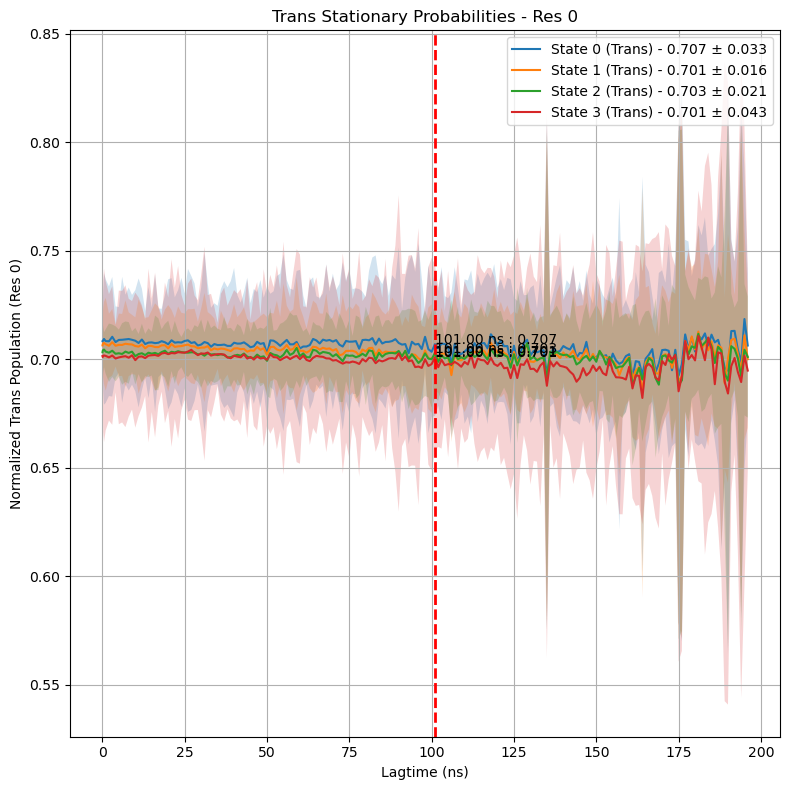

Traj 1, State 0: 101.00 ns : 0.468
Traj 1, State 1: 101.00 ns : 0.463
Traj 1, State 2: 101.00 ns : 0.463
Traj 1, State 3: 101.00 ns : 0.456


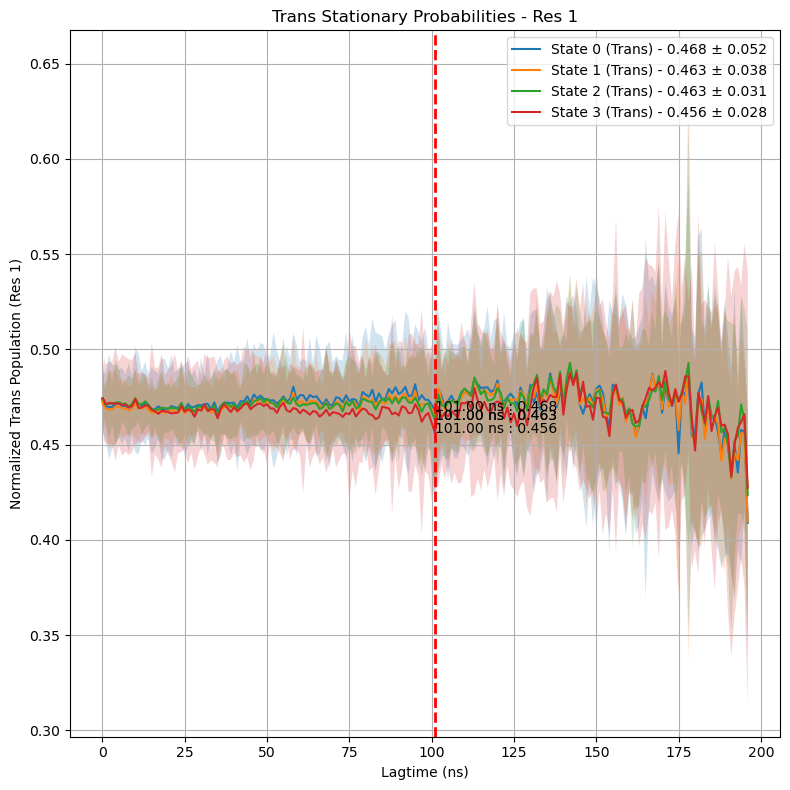

Traj 2, State 0: 101.00 ns : 0.600
Traj 2, State 1: 101.00 ns : 0.602
Traj 2, State 2: 101.00 ns : 0.605
Traj 2, State 3: 101.00 ns : 0.608


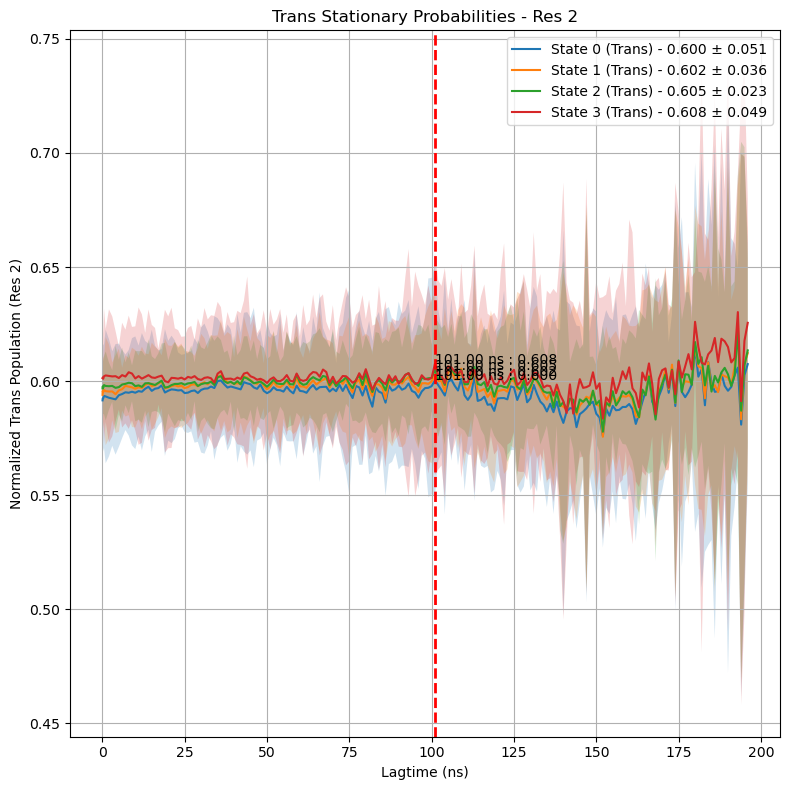

In [66]:
point_to_plot = 200
lagtime_plot = 104  # Index of lagtime to annotate

for res_index in range(3):
    plt.figure(figsize=(8, 8))

    for state_index in range(4):
        res = cis_trans_pi_means[state_index, res_index]   # shape (604, 2)
        std = cis_trans_pi_stds[state_index, res_index]    # shape (604, 2)

        # Plot trans population
        plt.plot(
            lagtimes_ns[:point_to_plot], 
            res[:point_to_plot, 1], 
            label=f"State {state_index} (Trans) - {res[lagtime_plot, 1]:.3f} ± {std[lagtime_plot, 1]:.3f}"
        )

        # Fill between ± std
        plt.fill_between(
            lagtimes_ns[:point_to_plot],
            res[:point_to_plot, 1] + std[:point_to_plot, 1],
            res[:point_to_plot, 1] - std[:point_to_plot, 1],
            alpha=0.2
        )

        # Annotate a specific lagtime point
        first_x = lagtimes_ns[lagtime_plot]
        first_y = res[lagtime_plot, 1]
        plt.text(first_x, first_y, f"{first_x:.2f} ns : {first_y:.3f}", fontsize=10)
        print(f"Traj {res_index}, State {state_index}: {first_x:.2f} ns : {first_y:.3f}")

    plt.axvline(x=first_x, color='r', linestyle='--', linewidth=2)

    plt.title(f"Trans Stationary Probabilities - Res {res_index}")
    plt.xlabel("Lagtime (ns)")
    plt.ylabel(f"Normalized Trans Population (Res {res_index})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [70]:
## Save the data into a csv

point_to_plot = 400
lagtime_plot = 104  # index of lagtime to extract at 101 ns
selected_ns = lagtimes_ns[lagtime_plot]  # for saving
state_num = 4

# Collect into a list of dicts for easy DataFrame creation
data_rows = []

for res_index in range(3):  # 3 trajectories
    for state_index in range(state_num):  # 6 states
        res = cis_trans_pi_means[state_index, res_index]  # shape (604, 2)
        std = cis_trans_pi_stds[state_index, res_index]

        mean_val = res[lagtime_plot, 1]  # Trans
        std_val = std[lagtime_plot, 1]

        data_rows.append({
            'res': res_index,
            'state': state_index,
            'lagtime_index': lagtime_plot,
            'lagtime_ns': selected_ns,
            'mean': mean_val,
            'std': std_val
        })

# Create a DataFrame
df = pd.DataFrame(data_rows)

# Save to CSV (or change to .tsv)
df.to_csv("autocoorel_data/trans_population_at_lagtime.csv", index=False)

print("Saved data to autocoorel_data/trans_population_at_lagtime.csv")


Saved data to autocoorel_data/trans_population_at_lagtime.csv


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_80730/759553138.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 10000)


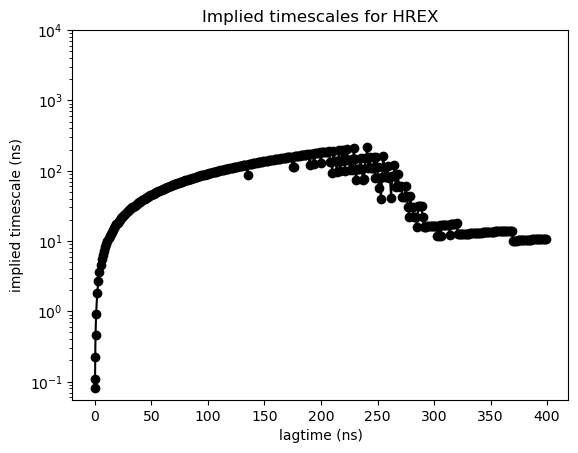

/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_80730/759553138.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 10000)


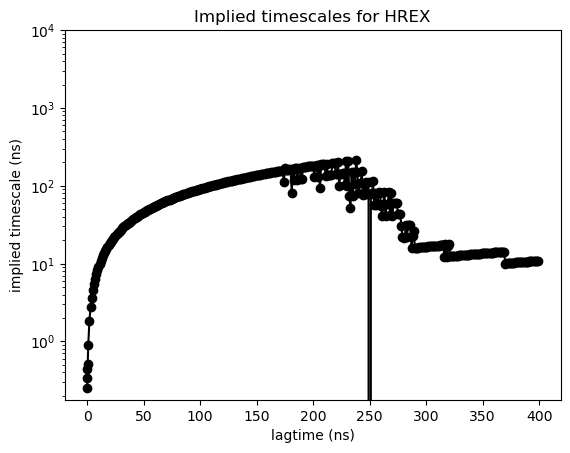

/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_80730/759553138.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 10000)


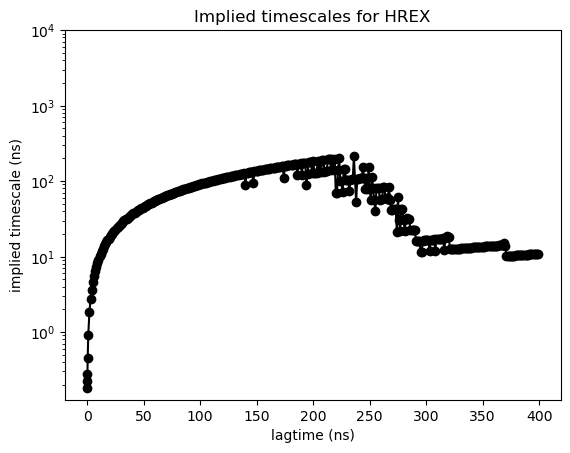

In [69]:
dt_in_ns = 0.01

plt.figure()

for i in range(3):
    plt.plot(lagtimes_ns, t2_all_means[i]*dt_in_ns, 'ko-')
    #plt.fill_between(lagtimes_ns, t2_all_uppers[i]*dt_in_ns, t2_all_lowers*dt_in_ns, alpha=0.2)
    plt.xlabel('lagtime (ns)')
    plt.ylabel('implied timescale (ns)')
    
    plt.yscale('log')
    plt.ylim(0, 10000)
    plt.title(f'Implied timescales for HREX')
    plt.show()
